# Model with Director Info & No Imputing

## Data Import and Profiling

### Importing the Data
Data available to download from IMDb Datasets: https://datasets.imdbws.com/ and https://www.imdb.com/interfaces/ for IMDb Dataset Details

#### **title.basics.tsv** - Contains the following information for titles:
| Column | Description |
| ----------- | ----------- |
| tconst (string) | alphanumeric unique identifier of the title |
| titleType (string) | the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc) |
| primaryTitle (string)| the more popular title / the title used by the filmmakers on promotional materials at the point of release |
| originalTitle (string) | original title, in the original language |
| isAdult (boolean) | 0: non-adult title; 1: adult title |
| startYear (YYYY) | represents the release year of a title. In the case of TV Series, it is the series start year |
| endYear (YYYY) | TV Series end year. ‘\N’ for all other title types |
| runtimeMinutes | primary runtime of the title, in minutes |
| genres (string array) | includes up to three genres associated with the title |

---

#### **title.ratings.tsv** – Contains the IMDb rating and votes information for titles
| Column | Description |
| ----------- | ----------- |
| tconst (string) | alphanumeric unique identifier of the title |
| averageRating | weighted average of all the individual user ratings |
| numVotes | number of votes the title has received |

---

#### **title.crew.tsv** – Contains the director and writer information for all the titles in IMDb.
| Column | Description |
| ----------- | ----------- |
| tconst (string) | alphanumeric unique identifier of the title |
| directors (array of nconsts) | director(s) of the given title |
| writers (array of nconsts) | writer(s) of the given title |

In [1]:
get_ipython().ast_node_interactivity = 'all'

In [2]:
#because the data set refreshes daily, writing a code to retrieve updated movie info from web
#https://stackoverflow.com/questions/31028815/how-to-unzip-gz-file-using-python

import requests
import gzip
import shutil
import urllib

data_to_download = ["title.basics.tsv", "title.ratings.tsv", "title.crew.tsv"]

for d in data_to_download:
    download_url = "https://datasets.imdbws.com/" + d + ".gz"
    gz_name = d + ".gz"
    tsv_name = d
    r = requests.get(download_url)
    
    with open(gz_name, "wb") as f:
        f.write(r.content)
        
    with gzip.open(gz_name, 'rb') as f_in:
        with open(tsv_name, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)


164109313

6276744

62988325

In [1]:
import numpy as np
import pandas
import openpyxl
import matplotlib
import datetime
import warnings

data_to_download = ["title.basics.tsv", "title.ratings.tsv", "title.crew.tsv"]

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
pandas.options.mode.chained_assignment = None


df_titles = pandas.read_csv(data_to_download[0], sep='\t')
df_title_ratings = pandas.read_csv(data_to_download[1], sep='\t')
df_crew = pandas.read_csv(data_to_download[2], sep='\t')

/var/folders/s3/z39zsndd4xgfz9_dz9kvk7n80000gn/T/ipykernel_41649/2748796473.py:15: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_titles = pandas.read_csv(data_to_download[0], sep='\t')


### Profiling the Crew/Director Data

In [2]:
#new dataset to extract the directors of each film as certain directors tend to get higher ratings than other directors
df_crew.head()

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N


In [3]:
df_crew.shape

(9388564, 3)

In [4]:
df_crew.dtypes

tconst       object
directors    object
writers      object
dtype: object

In [5]:
df_crew2=df_crew.replace('\\N', np.nan)
df_crew2.isna().sum()

tconst             0
directors    4009317
writers      4556538
dtype: int64

In [6]:
df_crew3=df_crew2.dropna()
df_crew3.isna().sum()
df_crew3.shape

(4140526, 3)

In [7]:
#dataset only including directors- better to use this since it drops less values and directors are more important indicator of ratings compared to writers
df_crew_alt=df_crew2.drop(columns=['writers'])
df_crew_alt2=df_crew_alt.dropna()
df_crew_alt2.isna().sum()
df_crew_alt2.shape

(5379247, 2)

In [8]:
#strange that there are directors who have directed over 10000 films
df_crew_alt2.directors.value_counts()

nm1203430                                   11010
nm1409127                                   10354
nm13220986                                   8024
nm5236281,nm5239804                          6940
nm0022750                                    6486
                                            ...  
nm12834595,nm2084315,nm4307762,nm5524750        1
nm2305978,nm2996961                             1
nm12831846                                      1
nm12831831                                      1
nm10538645                                      1
Name: directors, Length: 841401, dtype: int64

In [9]:
#putting directors in list
df_crew_alt2['directorList'] = df_crew_alt2['directors'].str.split(",")

In [10]:
df_crew_alt2.head()

,tconst,directors,directorList
0,tt0000001,nm0005690,[nm0005690]
1,tt0000002,nm0721526,[nm0721526]
2,tt0000003,nm0721526,[nm0721526]
3,tt0000004,nm0721526,[nm0721526]
4,tt0000005,nm0005690,[nm0005690]


In [11]:
df_crew_alt2['count'] = df_crew_alt2['directorList'].apply(len)

In [18]:
#Unrealistic for any movie/show to have more than 25 directors
df_crew_alt3 = df_crew_alt2.query("count <= 25")

In [19]:
df_crew_alt3.shape

(5378072, 4)

In [23]:
#Now finding whether director/directors have filmed more than 5 shows/movies

director_count = {}
for directorList in df_crew_alt3['directorList']:
    for director in directorList:
        if director in director_count:
            director_count[director] = director_count[director] + 1
        else:
            director_count[director] = 1

In [24]:
director_count

{'nm0005690': 184,
 'nm0721526': 13,
 'nm0374658': 77,
 'nm0085156': 1,
 'nm0525910': 134,
 'nm0804434': 26,
 'nm0525908': 11,
 'nm1587194': 2,
 'nm0932055': 132,
 'nm0010291': 30,
 'nm0666972': 57,
 'nm0617588': 532,
 'nm0895515': 59,
 'nm0684607': 3,
 'nm0795060': 8,
 'nm0234288': 36,
 'nm0698645': 106,
 'nm0609678': 1,
 'nm0349785': 457,
 'nm0924920': 506,
 'nm0714557': 2,
 'nm0808310': 318,
 'nm0095816': 167,
 'nm0005717': 130,
 'nm0422809': 2,
 'nm0085865': 188,
 'nm0471818': 11,
 'nm0692105': 313,
 'nm0378408': 135,
 'nm0182052': 6,
 'nm4427898': 10,
 'nm2156608': 1,
 'nm0002504': 3,
 'nm0177862': 91,
 'nm0807236': 44,
 'nm0561109': 7,
 'nm0793094': 8,
 'nm0095714': 3,
 'nm0675140': 10,
 'nm0954087': 165,
 'nm0958169': 3,
 'nm0634629': 130,
 'nm0881616': 13,
 'nm2092030': 8,
 'nm0035502': 9,
 'nm0555522': 4,
 'nm0353576': 38,
 'nm0832948': 294,
 'nm0159015': 233,
 'nm0253298': 168,
 'nm0742777': 29,
 'nm0567363': 70,
 'nm0002615': 5,
 'nm0172118': 227,
 'nm0789748': 75,
 'nm02804

In [26]:
def label_director_popularity(row, dict_directors):
    director_list = row['directorList']
    for director in director_list:
        if dict_directors[director] > 50:
            return 1
    return 0

In [27]:
df_crew_alt3.head().apply (lambda row: label_director_popularity(row, director_count), axis=1)

0    1
1    0
2    0
3    0
4    1
dtype: int64

In [28]:
df_crew_alt3['directors_popularity'] = df_crew_alt3.apply (lambda row: label_director_popularity(row, director_count), axis=1)


In [31]:
df_crew_alt3.directors_popularity.value_counts()

1    3264389
0    2113683
Name: directors_popularity, dtype: int64

### Profiling the Titles Data
- Removing columns that aren't needed
- Converting column data types
- Cleaning invalid data entries
- Removing NAs
- Splitting genres string into a list of the different genres

In [32]:
df_titles.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [33]:
df_titles.dtypes
#noticing that all datatypes are objects

tconst            object
titleType         object
primaryTitle      object
originalTitle     object
isAdult           object
startYear         object
endYear           object
runtimeMinutes    object
genres            object
dtype: object

In [34]:
#removing endYear column since not applicable to our model
df_titles_2 = df_titles.drop(columns=['endYear'])

In [35]:
#isAdult column should only have values 0 and 1 -> will clean to remove invalid entries
print(df_titles_2['isAdult'].unique())
df_titles_3 = df_titles_2.query("isAdult in (0, 1, '0', '1')")
print(df_titles_3['isAdult'].unique())
df_titles_3.head()

[0 1 2019 1981 2020 2017 '0' '1' '\\N' 2014 2005]
[0 1 '0' '1']


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,1,"Comedy,Short"


In [36]:
df_titles_3.dtypes

tconst            object
titleType         object
primaryTitle      object
originalTitle     object
isAdult           object
startYear         object
runtimeMinutes    object
genres            object
dtype: object

In [37]:
#Converting startYear, runtime, isAdult to numbers

#First removing any potential spaces/characters in these columns that would mess with the data type conversion
df_titles_3['startYear'] = df_titles_3['startYear'].str.replace(" ", "")
df_titles_3['runtimeMinutes'] = df_titles_3['runtimeMinutes'].str.replace(" ", "")

cols_to_convert = ['startYear', 'runtimeMinutes', 'isAdult']
df_titles_3[cols_to_convert] = df_titles_3[cols_to_convert].apply(pandas.to_numeric, errors='coerce')
print(df_titles_3.dtypes)
df_titles_3.head()

tconst             object
titleType          object
primaryTitle       object
originalTitle      object
isAdult             int64
startYear         float64
runtimeMinutes    float64
genres             object
dtype: object


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,1.0,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,5.0,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,4.0,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,12.0,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,1.0,"Comedy,Short"


In [38]:
#Seeing the number of rows and NAs
print(df_titles_3.shape)
df_titles_3.isna().sum()

(9388554, 8)


tconst                  0
titleType               0
primaryTitle           11
originalTitle          11
isAdult                 0
startYear         1261028
runtimeMinutes    6777562
genres                  0
dtype: int64

In [39]:
#Removing the rows that don't have start years or runtimes
df_titles_4 = df_titles_3.dropna()
print(df_titles_4.shape)
df_titles_4.isna().sum()
df_titles_4.dtypes

(2517317, 8)


tconst             object
titleType          object
primaryTitle       object
originalTitle      object
isAdult             int64
startYear         float64
runtimeMinutes    float64
genres             object
dtype: object

In [40]:
#Converting startYear to integers
df_titles_4['startYear'] = df_titles_4['startYear'].astype(object)
df_titles_4.head()
# should it be integer or categorical // date type

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,1.0,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,5.0,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,4.0,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,12.0,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,1.0,"Comedy,Short"


In [41]:
#Seeing all the different title types
df_titles_4['titleType'].value_counts()
df_titles_4.dtypes

tconst             object
titleType          object
primaryTitle       object
originalTitle      object
isAdult             int64
startYear          object
runtimeMinutes    float64
genres             object
dtype: object

In [42]:
#Seeing all of the unique genres and separating the strings into a list of each genre
print(df_titles_4['genres'].unique())
df_titles_4['genres'] = df_titles_4['genres'].str.split(",")
df_titles_4.head()

['Documentary,Short' 'Animation,Short' 'Animation,Comedy,Romance' ...
 'Mystery,Reality-TV,Thriller' 'Musical,News,Reality-TV'
 'Drama,Horror,Reality-TV']


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,1.0,"[Documentary, Short]"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,5.0,"[Animation, Short]"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,4.0,"[Animation, Comedy, Romance]"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,12.0,"[Animation, Short]"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,1.0,"[Comedy, Short]"


### Joining the Data
- Profile ratings data
- Inner join two tables by the title ID

In [43]:
#Now looking at the title_ratings table to see if there are any initial outliers
df_title_ratings.describe()

,averageRating,numVotes
count,1.250092e+06,1.250092e+06
mean,6.950149e+00,1.041675e+03
std,1.389639e+00,1.728294e+04
min,1.000000e+00,5.000000e+00
25%,6.200000e+00,1.200000e+01
50%,7.100000e+00,2.600000e+01
75%,7.900000e+00,1.010000e+02
max,1.000000e+01,2.663062e+06


In [44]:
#No NAs in ratings table
df_title_ratings.isna().sum()

tconst           0
averageRating    0
numVotes         0
dtype: int64

In [45]:
#Merging the two tables on tconst as the title ID
df_combine= df_titles_4.merge(df_title_ratings, on='tconst', how='inner')
df_combine.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,1.0,"[Documentary, Short]",5.7,1923
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,5.0,"[Animation, Short]",5.8,259
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,4.0,"[Animation, Comedy, Romance]",6.5,1737
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,12.0,"[Animation, Short]",5.6,174
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,1.0,"[Comedy, Short]",6.2,2550


In [46]:
# checking for NAs // misalignment 
df_combine.isna().sum()

tconst            0
titleType         0
primaryTitle      0
originalTitle     0
isAdult           0
startYear         0
runtimeMinutes    0
genres            0
averageRating     0
numVotes          0
dtype: int64

In [48]:
df_all = df_combine.merge(df_crew_alt3, on='tconst', how='inner')
df_all.head()
df_all.isna().sum()

tconst                  0
titleType               0
primaryTitle            0
originalTitle           0
isAdult                 0
startYear               0
runtimeMinutes          0
genres                  0
averageRating           0
numVotes                0
directors               0
directorList            0
count                   0
directors_popularity    0
dtype: int64

In [49]:
#Seeing how many rows are returned --> after profiling the data, left with 900K instances
df_all.shape

(805968, 14)

In [50]:
df_all.describe()

,isAdult,runtimeMinutes,averageRating,numVotes,count,directors_popularity
count,805968.000000,805968.000000,805968.000000,8.059680e+05,805968.000000,805968.000000
mean,0.016375,57.698600,6.854610,1.549837e+03,1.281968,0.467502
std,0.126914,99.824392,1.339322,2.129506e+04,1.192692,0.498943
min,0.000000,0.000000,1.000000,5.000000e+00,1.000000,0.000000
25%,0.000000,24.000000,6.100000,1.500000e+01,1.000000,0.000000
50%,0.000000,48.000000,7.000000,4.300000e+01,1.000000,0.000000
75%,0.000000,88.000000,7.800000,1.870000e+02,1.000000,1.000000
max,1.000000,51420.000000,10.000000,2.663062e+06,25.000000,1.000000


### Creating and Joining Genres
Currently genres is stored as a list under the genres column - we want to convert those genres into columns so that we can use each genre as a categorical variable in our model
- create dataframe with each genre as separate column
- remove rows with genres that were /N
- join the genre dataframe with our main dataframe

In [51]:
#Creating dataframe with crosstab of imdb entry and the different genres they're listed under
df_genres = df_all.genres.apply(','.join).str.get_dummies(sep=',')
df_genres.insert(0, 'tconst', df_all['tconst'])
display(df_genres)

,tconst,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,\N
0,tt0000001,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,tt0000002,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,tt0000003,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,tt0000004,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,tt0000005,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805963,tt9916580,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
805964,tt9916682,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
805965,tt9916690,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
805966,tt9916720,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
#crosstab of years as categorical variables
#df_year = pandas.get_dummies(df_all.startYear)
#df_year.insert(0, 'tconst', df_all['tconst'])
#display(df_year)

In [53]:
#Removing the /N column that represepnds the NA values in the list of genres
print(df_genres['\\N'].sum()) #shows that there are 9616 instances of NA genre
df_genres = df_genres.drop(['\\N'], axis=1)

8489


In [54]:
#Finding number of genres for each row
df_genres['count'] = df_genres.loc[:, df_genres.columns != 'tconst' ].sum(axis=1)
df_genres['count'].value_counts()

3    289179
1    266572
2    241728
0      8489
Name: count, dtype: int64

In [55]:
#Removing the rows that had NA genres (or zero genre count)
df_genres = df_genres.query( "count > 0" )

In [56]:
#Finding the number of instances under each genres across entire data
for (columnName, columnData) in df_genres.iteritems():
    if (columnName not in ['tconst', 'count']):
        print(columnName, ":", columnData.sum())

Action : 95557
Adult : 12853
Adventure : 84820
Animation : 86392
Biography : 17459
Comedy : 251189
Crime : 95384
Documentary : 95612
Drama : 317420
Family : 59285
Fantasy : 36035
Film-Noir : 857
Game-Show : 9988
History : 21804
Horror : 42420
Music : 21917
Musical : 9338
Mystery : 45642
News : 4747
Reality-TV : 17559
Romance : 66310
Sci-Fi : 24051
Short : 118750
Sport : 8679
Talk-Show : 7582
Thriller : 41035
War : 10445
Western : 14435


In [57]:
#Joining the two dataframes
df_all_final = df_all.merge(df_genres, on='tconst', how='inner')
display(df_all_final)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,...,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,count_y
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,1.0,"[Documentary, Short]",5.7,1923,...,0,0,0,1,0,0,0,0,0,2
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,5.0,"[Animation, Short]",5.8,259,...,0,0,0,1,0,0,0,0,0,2
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,4.0,"[Animation, Comedy, Romance]",6.5,1737,...,0,1,0,0,0,0,0,0,0,3
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,12.0,"[Animation, Short]",5.6,174,...,0,0,0,1,0,0,0,0,0,2
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,1.0,"[Comedy, Short]",6.2,2550,...,0,0,0,1,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797474,tt9916578,tvEpisode,The Trial of Joan Collins,The Trial of Joan Collins,0,2019.0,44.0,"[Adventure, Biography, Comedy]",7.4,43,...,0,0,0,0,0,0,0,0,0,3
797475,tt9916580,tvEpisode,Horrid Henry Horrid Boy?,Horrid Henry Horrid Boy?,0,2012.0,10.0,"[Adventure, Animation, Comedy]",8.5,7,...,0,0,0,0,0,0,0,0,0,3
797476,tt9916682,tvEpisode,Horrid Henry It's all Your Fault,Horrid Henry It's all Your Fault,0,2012.0,10.0,"[Adventure, Animation, Comedy]",6.4,6,...,0,0,0,0,0,0,0,0,0,3
797477,tt9916690,tvEpisode,Horrid Henry Delivers the Milk,Horrid Henry Delivers the Milk,0,2012.0,10.0,"[Adventure, Animation, Comedy]",7.4,6,...,0,0,0,0,0,0,0,0,0,3


In [58]:
display(df_all_final)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,...,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,count_y
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,1.0,"[Documentary, Short]",5.7,1923,...,0,0,0,1,0,0,0,0,0,2
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,5.0,"[Animation, Short]",5.8,259,...,0,0,0,1,0,0,0,0,0,2
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,4.0,"[Animation, Comedy, Romance]",6.5,1737,...,0,1,0,0,0,0,0,0,0,3
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,12.0,"[Animation, Short]",5.6,174,...,0,0,0,1,0,0,0,0,0,2
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,1.0,"[Comedy, Short]",6.2,2550,...,0,0,0,1,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797474,tt9916578,tvEpisode,The Trial of Joan Collins,The Trial of Joan Collins,0,2019.0,44.0,"[Adventure, Biography, Comedy]",7.4,43,...,0,0,0,0,0,0,0,0,0,3
797475,tt9916580,tvEpisode,Horrid Henry Horrid Boy?,Horrid Henry Horrid Boy?,0,2012.0,10.0,"[Adventure, Animation, Comedy]",8.5,7,...,0,0,0,0,0,0,0,0,0,3
797476,tt9916682,tvEpisode,Horrid Henry It's all Your Fault,Horrid Henry It's all Your Fault,0,2012.0,10.0,"[Adventure, Animation, Comedy]",6.4,6,...,0,0,0,0,0,0,0,0,0,3
797477,tt9916690,tvEpisode,Horrid Henry Delivers the Milk,Horrid Henry Delivers the Milk,0,2012.0,10.0,"[Adventure, Animation, Comedy]",7.4,6,...,0,0,0,0,0,0,0,0,0,3


In [59]:
#df_all_final = df_all_combine.merge(df_year, on='tconst', how='inner')
#display(df_all_final)

In [60]:
df_all_final.describe()

,isAdult,runtimeMinutes,averageRating,numVotes,count_x,directors_popularity,Action,Adult,Adventure,Animation,...,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,count_y
count,797479.000000,797479.000000,797479.000000,7.974790e+05,797479.000000,797479.000000,797479.000000,797479.000000,797479.000000,797479.000000,...,797479.000000,797479.000000,797479.000000,797479.000000,797479.000000,797479.000000,797479.000000,797479.000000,797479.000000,797479.000000
mean,0.016347,57.334421,6.858971,1.565990e+03,1.282515,0.469290,0.119824,0.016117,0.106360,0.108331,...,0.022018,0.083150,0.030159,0.148907,0.010883,0.009507,0.051456,0.013098,0.018101,2.028348
std,0.126804,91.852522,1.337377,2.140751e+04,1.194316,0.499056,0.324756,0.125926,0.308298,0.310799,...,0.146743,0.276108,0.171024,0.355997,0.103753,0.097042,0.220926,0.113693,0.133316,0.834315
min,0.000000,0.000000,1.000000,5.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,23.000000,6.100000,1.500000e+01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,47.000000,7.000000,4.400000e+01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,0.000000,88.000000,7.800000,1.900000e+02,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.000000,51420.000000,10.000000,2.663062e+06,25.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


In [61]:
df_all_final.dtypes

tconst                   object
titleType                object
primaryTitle             object
originalTitle            object
isAdult                   int64
startYear                object
runtimeMinutes          float64
genres                   object
averageRating           float64
numVotes                  int64
directors                object
directorList             object
count_x                   int64
directors_popularity      int64
Action                    int64
Adult                     int64
Adventure                 int64
Animation                 int64
Biography                 int64
Comedy                    int64
Crime                     int64
Documentary               int64
Drama                     int64
Family                    int64
Fantasy                   int64
Film-Noir                 int64
Game-Show                 int64
History                   int64
Horror                    int64
Music                     int64
Musical                   int64
Mystery 

### Visualizing the Data
- Distribution of ratings
- Distribution of ratings for movies longer than 100 minutes and from 2000 forward
- Distribution of ratings for movies in 2022
- Distribution of ratings for tv episodes
- Distribtion of ratings for short films
- Distribution of ratings for full movies

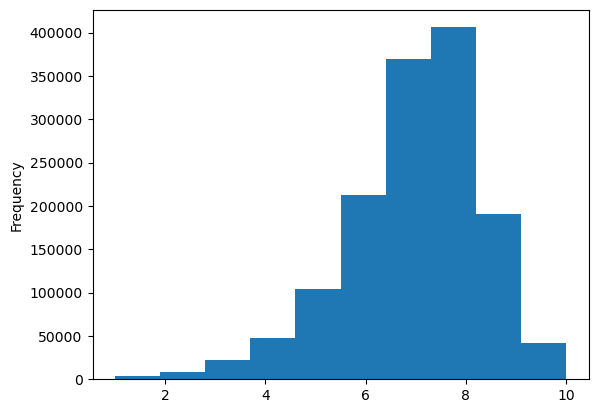

In [49]:
hist = df_all_final[ 'averageRating' ].plot.hist()

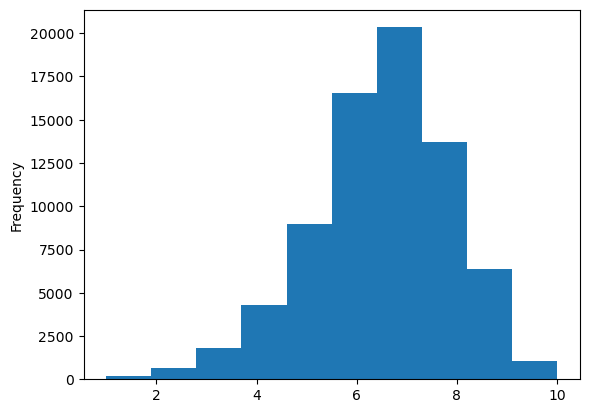

In [50]:
hist1 = df_all_final.query( "(runtimeMinutes >= 100) & (startYear > 2000)" )[ 'averageRating' ].plot.hist()

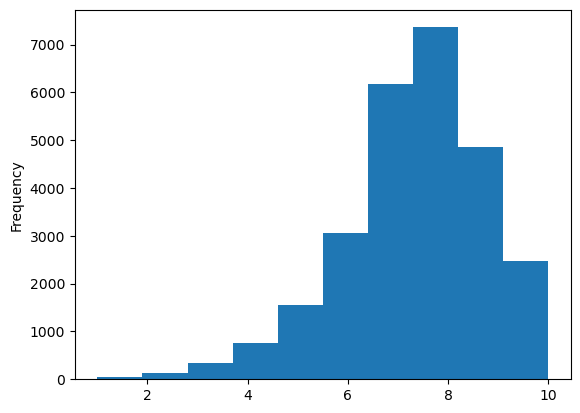

In [51]:
hist2 = df_all_final.query( "(startYear== 2022)" )[ 'averageRating' ].plot.hist()

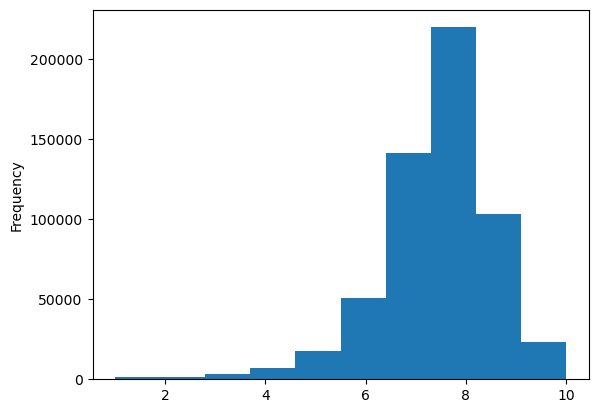

In [52]:
hist3 = df_all_final.query( "(titleType == 'tvEpisode')" )[ 'averageRating' ].plot.hist()

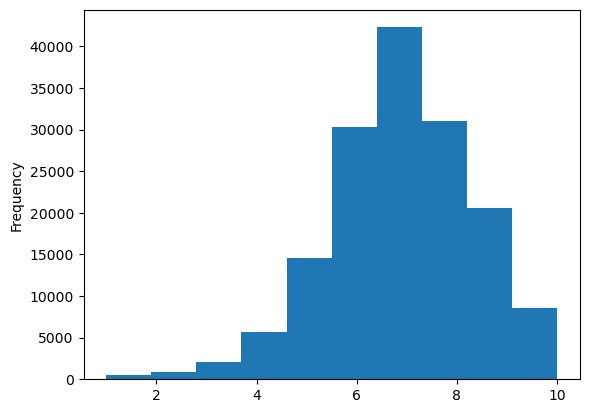

In [53]:
hist3 = df_all_final.query( "(titleType == 'short')" )[ 'averageRating' ].plot.hist()

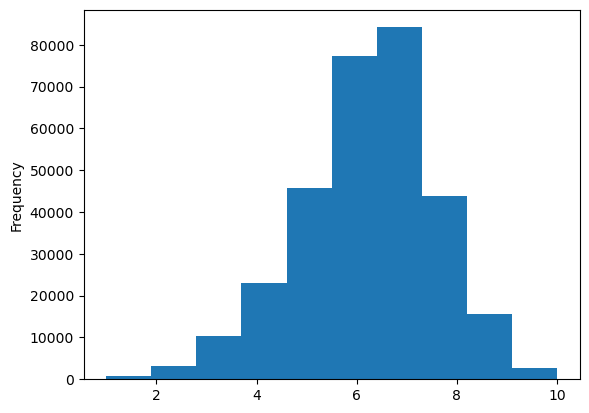

In [54]:
hist3 = df_all_final.query( "(titleType == 'movie')" )[ 'averageRating' ].plot.hist()

0    1386090
1      20489
Name: isAdult, dtype: int64


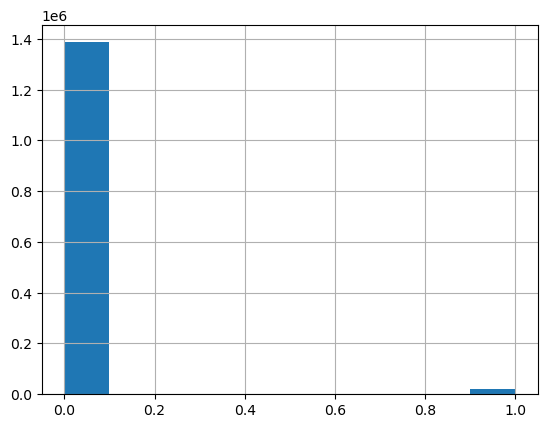

In [55]:
#We see that most of entries in data are non-adult titles
print(df_all_final['isAdult'].value_counts())
hist = df_all_final['isAdult'].hist()

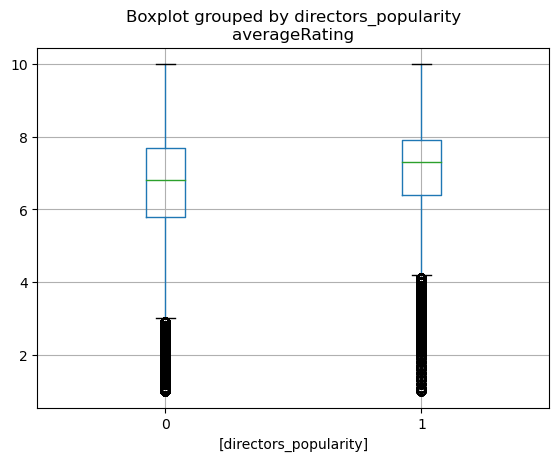

In [62]:
plot = df_all_final.boxplot( column=[ 'averageRating' ], by =[ 'directors_popularity' ] )

### Writing Cleaned DataFrame to CSV
Exporting the new joined and cleaned csv into new file so that we don't need to re-profile every time

In [63]:
df_all_final.to_csv('ratings_cleaned_with_directors.csv', index=False)

# Modeling
First using Linear Regression to predict the movie rating, then trying various models to find the better R^2 scores

### Import Data
- from clean csv that we wrote our profiled data into

In [64]:
import pandas

df = pandas.read_csv('ratings_cleaned_with_directors.csv')
df.shape

(797479, 43)

In [65]:
model_test_scores = {}

### Preprocessor

In [68]:
import numpy
rng = numpy.random.RandomState( 28 )

from sklearn.model_selection import train_test_split
X = df
y = df['averageRating']
X_train, X_test, y_train, y_test = train_test_split( X, y, random_state=rng, test_size=0.5 )

lstNum1 = list(df.columns[~df.columns.isin(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'genres', 'averageRating', 'count_x', 'count_y', 'directors', 'directorList'])].values)      
lstCat1 = ['titleType']

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
pipeNum1 = Pipeline( [
    ('selector', ColumnTransformer([ ('selector' , 'passthrough', lstNum1) ]) ),
    ('scaler', StandardScaler())
])

from sklearn.preprocessing import OneHotEncoder
pipeCat1 = Pipeline([
    ('selector', ColumnTransformer([('selector' , 'passthrough', lstCat1 )]) ),
    ('encoder', OneHotEncoder(dtype = int, drop = 'first', handle_unknown='ignore' ))
])

from sklearn.pipeline import FeatureUnion
preprocessor1 = FeatureUnion([
    ('cat', pipeCat1),
    ('num', pipeNum1)
])

### Linear Regression

In [69]:
#Linear Regression
from sklearn.linear_model import LinearRegression
pipeLnRg1 = Pipeline([
    ('preprocessor', preprocessor1),
    ('model', LinearRegression() )
    ], verbose=True )

pipeLnRg1.fit( X_train, y_train )

predTrainLnRg1 = pipeLnRg1.predict(X_train)
predTestLnRg1 = pipeLnRg1.predict(X_test)

import sklearn.metrics as model
print("Linear Regression Train Data R^2 score:", model.r2_score( y_train, predTrainLnRg1 ))
print("Linear Regression Test Data R^2 score:", model.r2_score (y_test, predTestLnRg1))

model_test_scores['LnRg Full Data'] = model.r2_score (y_test, predTestLnRg1)
#We see the initial score is very very low

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   1.4s
[Pipeline] ............. (step 2 of 2) Processing model, total=   1.9s
Linear Regression Train Data R^2 score: 0.23378420900167773
Linear Regression Test Data R^2 score: 0.23323674956739027


### Random Forest Regressor
- using reduced data

In [70]:
#originally using all of the data took to long to process so decided to only use the first 40,000 rows

from sklearn.model_selection import train_test_split
df_reduced = df.sample(n = 40000, random_state = rng).query( "titleType != 'videoGame' ")
#filtering out videogame to avoid errors/unrecognized data since original dataset only had 327 instances

X_r = df_reduced
y_r = df_reduced['averageRating']
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split( X_r, y_r, random_state=rng, test_size=0.5 )

In [71]:
from sklearn.ensemble import RandomForestRegressor
pipeRf1 = Pipeline([
    ('preprocessor', preprocessor1 ),
    ('model', RandomForestRegressor() )
    ], verbose=True )

pipeRf1.fit( X_train_r, y_train_r )
predTrainRf1 = pipeRf1.predict(X_train_r)
predTestRf1 = pipeRf1.predict(X_test_r)

print("Random Forest Train Data R^2 Score: ", model.r2_score( y_train_r, predTrainRf1 ))
print("Random Forest Test Data R^2 Score: ", model.r2_score( y_test_r, predTestRf1 ))

model_test_scores['Rf Reduced Data'] = model.r2_score (y_test_r, predTestRf1)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total= 2.6min
Random Forest Train Data R^2 Score:  0.904759314657187
Random Forest Test Data R^2 Score:  0.3080944518777661


In [72]:
#feature analysis finding that runtimeMinutes, numVotes, startYear, titleType, Documentary, Horror, Drama, Comedy, Ation, Romance contribute the most
pandas.Series( pipeRf1[ "model" ].feature_importances_, index=pipeRf1[:-1].
                      get_feature_names_out() ).sort_values(ascending=False)

num__selector__runtimeMinutes            0.239182
num__selector__numVotes                  0.198140
num__selector__startYear                 0.173941
cat__selector__titleType_tvEpisode       0.097704
num__selector__Documentary               0.040155
num__selector__Horror                    0.027184
num__selector__Comedy                    0.019070
num__selector__Drama                     0.018960
num__selector__directors_popularity      0.017239
num__selector__Action                    0.011949
num__selector__Romance                   0.011555
num__selector__Crime                     0.009871
num__selector__Family                    0.009857
num__selector__Adventure                 0.008869
num__selector__Thriller                  0.008783
cat__selector__titleType_video           0.008533
num__selector__Animation                 0.008437
cat__selector__titleType_tvMovie         0.008302
num__selector__Sci-Fi                    0.007532
num__selector__Fantasy                   0.006907


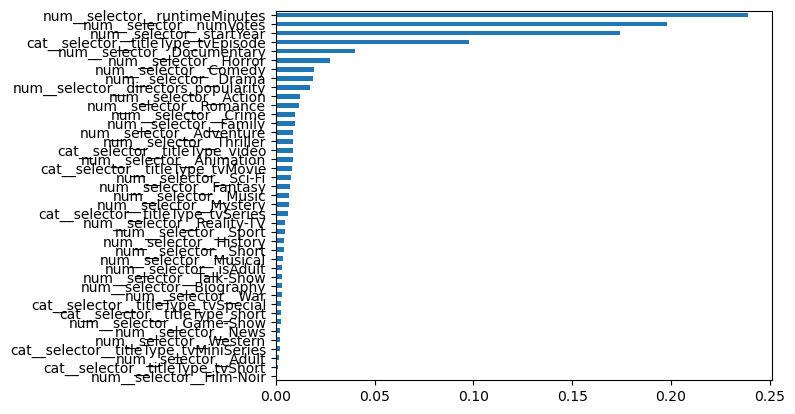

In [73]:
rfBar =pandas.Series( pipeRf1[ "model" ].feature_importances_, index=pipeRf1[:-1].
                      get_feature_names_out() ).sort_values(ascending=True).plot.barh()

### Gradient Boosting Regressor
- first ran with default parameters then used gridsearch for hypertuning

In [74]:
#Gradient Regression
from sklearn.ensemble import GradientBoostingRegressor
pipeGb1 = Pipeline([
    ('preprocessor', preprocessor1 ),
    ('model', GradientBoostingRegressor() )
    ], verbose=True )

pipeGb1.fit( X_train, y_train )

predTrainGb1 = pipeGb1.predict(X_train)
predTestGb1 = pipeGb1.predict(X_test)

import sklearn.metrics as model

print("Gradient Boosted Train Data R^2 Score: ", model.r2_score( y_train, predTrainGb1 ))
print("Gradient Boosted Test Data R^2 Score: ", model.r2_score( y_test, predTestGb1 ))

model_test_scores['Gb Full Data'] = model.r2_score (y_test, predTestGb1)
#Better score but took a lot longer to process

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   2.3s
[Pipeline] ............. (step 2 of 2) Processing model, total= 2.0min
Gradient Boosted Train Data R^2 Score:  0.3161546481824944
Gradient Boosted Test Data R^2 Score:  0.31359288607235913


In [75]:
#Rerunning Gradient Boost with less data
pipeGb1.fit( X_train_r, y_train_r )

predTrainGb1_r = pipeGb1.predict(X_train_r)
predTestGb1_r = pipeGb1.predict(X_test_r)

print("Gradient Boosted Train Data R^2 Score: ", model.r2_score( y_train_r, predTrainGb1_r ))
print("Gradient Boosted Test Data R^2 Score: ", model.r2_score( y_test_r, predTestGb1_r ))

model_test_scores['Gb Reduced Data'] = model.r2_score (y_test_r, predTestGb1_r)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=   3.7s
Gradient Boosted Train Data R^2 Score:  0.3397170002766472
Gradient Boosted Test Data R^2 Score:  0.3052945825808788


In [76]:
#Hypertuning to get better Gb score
paramGridGb = {
    "model__n_estimators": [50, 100, 500, 1000],
    "model__max_leaf_nodes": [5, 10, 50, 100],
    "model__learning_rate": [ 0.15, 0.45, 0.75 ],
}

from sklearn.model_selection import GridSearchCV
gridGb = GridSearchCV( pipeGb1, paramGridGb, cv=5, n_jobs=-1, verbose = 4)

gridGb.fit(X_train_r, y_train_r)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=  23.8s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        FeatureUnion(transformer_list=[('cat',
                                                                        Pipeline(steps=[('selector',
                                                                                         ColumnTransformer(transformers=[('selector',
                                                                                                                          'passthrough',
                                                                                                                          ['titleType'])])),
                                                                                        ('encoder',
                                                                                         OneHotEncoder(drop='first',
                                                                                                       dtype=<class 'int'>,
                                                                                                       handle_unknown='ignore'))])),
                                                                       ('num',
                                                                        Pipeline(steps=[('selector',
                                                                                         ColumnTransformer(transform...
                                                                                                                           'Horror',
                                                                                                                           'Music',
                                                                                                                           'Musical',
                                                                                                                           'Mystery',
                                                                                                                           'News',
                                                                                                                           'Reality-TV',
                                                                                                                           'Romance',
                                                                                                                           'Sci-Fi',
                                                                                                                           'Short',
                                                                                                                           'Sport',
                                                                                                                           'Talk-Show', ...])])),
                                                                                        ('scaler',
                                                                                         StandardScaler())]))])),
                                       ('model', GradientBoostingRegressor())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.15, 0.45, 0.75],
                         'model__max_leaf_nodes': [5, 10, 50, 100],
                         'model__n_estimators': [50, 100, 500, 1000]},
             verbose=4)

In [77]:
print("Best Parameters:", gridGb.best_params_)
print("Score with Best Parameters:", gridGb.best_score_)

Best Parameters: {'model__learning_rate': 0.15, 'model__max_leaf_nodes': 50, 'model__n_estimators': 500}
Score with Best Parameters: 0.34245431634197754


In [78]:
#Retrying with optimized parameters and reduced data

pipeGb2 = Pipeline([
    ('preprocessor', preprocessor1 ),
    ('model', GradientBoostingRegressor(learning_rate= 0.15, max_leaf_nodes=50, n_estimators=500) )
    ], verbose=True )

pipeGb2.fit( X_train_r, y_train_r )

predTrainGb2_r = pipeGb2.predict(X_train_r)
predTestGb2_r = pipeGb2.predict(X_test_r)

print("Gradient Boosted Train Data R^2 Score: ", model.r2_score( y_train_r, predTrainGb2_r ))
print("Gradient Boosted Test Data R^2 Score: ", model.r2_score( y_test_r, predTestGb2_r ))

model_test_scores['Gb Tuned Reduced Data'] = model.r2_score( y_test_r, predTestGb2_r )

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=  17.7s
Gradient Boosted Train Data R^2 Score:  0.4290976657955695
Gradient Boosted Test Data R^2 Score:  0.3273493805212314


In [79]:
#Retrying with optimized parameters and full data

pipeGb2.fit( X_train, y_train )

predTrainGb2 = pipeGb2.predict(X_train)
predTestGb2 = pipeGb2.predict(X_test)

print("Gradient Boosted Train Data R^2 Score: ", model.r2_score( y_train, predTrainGb2 ))
print("Gradient Boosted Test Data R^2 Score: ", model.r2_score( y_test, predTestGb2 ))

model_test_scores['Gb Tuned Full Data'] = model.r2_score( y_test, predTestGb2 )

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   1.8s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipeline] ............. (step 2 of 2) Processing model, total=   4.0s
[CV 3/5] END model__learning_rate=0.15, model__max_leaf_nodes=5, model__n_estimators=50;, score=0.307 total time=   4.4s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=  35.5s
[CV 1/5] END model__learning_rate=0.15, model__max_leaf_nodes=5, model__n_estimators=500;, score=0.359 total time=  35.9s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.2s
[Pipeline] ............. (step 2 of 2) Processing model, total= 1.2min
[CV 5/5] END model__learning_rate=0.15, model__max_leaf_nodes=5, model__n_estimators=1000;, score=0.339 total time= 1.3min
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total= 1.

### Neural Networks
- first ran with 3 layers of 10 nodes, then used gridsearch for hypertuning

In [112]:
#trying Neural Networks
from sklearn.neural_network import MLPRegressor

pipeNn1 = Pipeline([
    ('preprocessor', preprocessor1 ),
    ('model', MLPRegressor(hidden_layer_sizes = (10,10,10), max_iter = 2000, random_state=28 ) )
    ], verbose = True)

pipeNn1.fit(X_train_r, y_train_r)
predTrainNn1_r = pipeNn1.predict( X_train_r )
predTestNn1_r = pipeNn1.predict( X_test_r )

print("Neural Network Train Data R^2 Score: ", model.r2_score( y_train_r, predTrainNn1_r ))
print("Neural Network Test Data R^2 Score: ", model.r2_score( y_test_r, predTestNn1_r ))

model_test_scores['Nn1 Reduced Data'] = model.r2_score( y_test_r, predTestNn1_r )

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.2s
[Pipeline] ............. (step 2 of 2) Processing model, total=  11.9s
Neural Network Train Data R^2 Score:  0.3222777278472727
Neural Network Test Data R^2 Score:  0.27225844210369265


In [ ]:
#Neural Network Hypertuning

pipeNnGrid = Pipeline([
    ('preprocessor', preprocessor1 ),
    ('model', MLPRegressor(max_iter = 2000, random_state=28 ) )
    ])

from sklearn.model_selection import GridSearchCV
paramGridNn = {
    'model__hidden_layer_sizes': [(10), (100), (10,10,10), (100,100,100)],
    'model__activation': ['tanh', 'relu', 'identity', 'logistic'],
    'model__alpha': [0.0001, 1, 10]
}

gridNn = GridSearchCV( pipeNnGrid, paramGridNn, cv=5, n_jobs=-1 , verbose = 4)

gridNn.fit(X_train_r, y_train_r)

In [ ]:
print("Best Parameters:", gridNn.best_params_)
print("Score with Best Parameters:", gridNn.best_score_)

In [113]:
#trying with new parameters 

pipeNn2 = Pipeline([
    ('preprocessor', preprocessor1 ),
    ('model', MLPRegressor(hidden_layer_sizes = (10,10,10),activation ='tanh', alpha = 1,max_iter = 2000, random_state=28 ) )
    ], verbose = True)

pipeNn2.fit(X_train_r, y_train_r)
predTrainNn2_r = pipeNn2.predict( X_train_r )
predTestNn2_r = pipeNn2.predict( X_test_r )

print("Neural Network Train Data R^2 Score: ", model.r2_score( y_train_r, predTrainNn2_r ))
print("Neural Network Test Data R^2 Score: ", model.r2_score( y_test_r, predTestNn2_r ))

model_test_scores['Nn2 Reduced Data'] = model.r2_score( y_test_r, predTestNn2_r )

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=   9.1s
Neural Network Train Data R^2 Score:  0.3280382501855603
Neural Network Test Data R^2 Score:  0.2886331996398711


# Feature Engineering
Adjusting the genre and categorical features to potentially get more information out of the data

#### New Column afterIMDB
New feature with categories of whether Movies/Shows  came out before or after IMDB started as Company

In [114]:
df2 = df.copy()

In [115]:
df2['afterIMDB'] = numpy.where(df2['startYear'] > 1990, 1, 0)

In [116]:
df2[['originalTitle', 'startYear', 'afterIMDB']]

,originalTitle,startYear,afterIMDB
0,Carmencita,1894.0,0
1,Le clown et ses chiens,1892.0,0
2,Pauvre Pierrot,1892.0,0
3,Un bon bock,1892.0,0
4,Blacksmith Scene,1893.0,0
...,...,...,...
797474,The Trial of Joan Collins,2019.0,1
797475,Horrid Henry Horrid Boy?,2012.0,1
797476,Horrid Henry It's all Your Fault,2012.0,1
797477,Horrid Henry Delivers the Milk,2012.0,1


In [117]:
df2.afterIMDB.value_counts()

1    595622
0    201857
Name: afterIMDB, dtype: int64

#### Consolidating titleType
Simplifying titleType to either be tv, movie, or other

In [118]:
df2.titleType.value_counts()

tvEpisode       302988
movie           248451
short           122354
tvSeries         39110
tvMovie          38392
video            31548
tvMiniSeries      7529
tvSpecial         5017
tvShort           2029
videoGame           61
Name: titleType, dtype: int64

In [119]:
df2['titleType2'] = numpy.where(df2.titleType.str.contains("tv"), "tv",
    numpy.where(df2.titleType.str.contains("movie"), "movie",
    numpy.where(df2.titleType.str.contains("short"), "movie",
    "other")))

df2[['originalTitle', 'titleType', 'titleType2']]

,originalTitle,titleType,titleType2
0,Carmencita,short,movie
1,Le clown et ses chiens,short,movie
2,Pauvre Pierrot,short,movie
3,Un bon bock,short,movie
4,Blacksmith Scene,short,movie
...,...,...,...
797474,The Trial of Joan Collins,tvEpisode,tv
797475,Horrid Henry Horrid Boy?,tvEpisode,tv
797476,Horrid Henry It's all Your Fault,tvEpisode,tv
797477,Horrid Henry Delivers the Milk,tvEpisode,tv


In [120]:
df2.titleType2.value_counts()

tv       395065
movie    370805
other     31609
Name: titleType2, dtype: int64

#### Consolidate Movies/Shows that are Short
Combining titleType = short and Short (from genre) into one column

In [121]:
df2['Short'] = numpy.where(df2.titleType.str.contains("short"), 1, 
                            numpy.where(df2.Short == 1, 1,
                            0))

In [122]:
df2[['titleType', 'Short']]

,titleType,Short
0,short,1
1,short,1
2,short,1
3,short,1
4,short,1
...,...,...
797474,tvEpisode,0
797475,tvEpisode,0
797476,tvEpisode,0
797477,tvEpisode,0


In [123]:
df2.Short.value_counts()

0    663579
1    133900
Name: Short, dtype: int64

#### Consolidate Movies/Shows that are Adult
Combining isAdult column and Adult (from genre) into one column

In [124]:
df2[['Adult', 'isAdult']].query('Adult != isAdult').shape

(331, 2)

In [125]:
df2[['Adult', 'isAdult']].query('Adult == 1 and isAdult == 1').shape

(12779, 2)

In [126]:
df2['Adult'] = numpy.where(df2.isAdult == 1, 1, 
                            numpy.where(df2.Adult == 1, 1,
                            0))

In [127]:
df2.Adult.value_counts()

0    784369
1     13110
Name: Adult, dtype: int64

In [128]:
df2.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,...,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,count_y,afterIMDB,titleType2
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,1.0,"['Documentary', 'Short']",5.7,1923,...,0,1,0,0,0,0,0,2,0,movie
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,5.0,"['Animation', 'Short']",5.8,259,...,0,1,0,0,0,0,0,2,0,movie
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,4.0,"['Animation', 'Comedy', 'Romance']",6.5,1737,...,0,1,0,0,0,0,0,3,0,movie
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,12.0,"['Animation', 'Short']",5.6,174,...,0,1,0,0,0,0,0,2,0,movie
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,1.0,"['Comedy', 'Short']",6.2,2550,...,0,1,0,0,0,0,0,2,0,movie


In [129]:
df2.shape

(797479, 45)

#### Changing popularity of directors to be more specific

In [137]:
df2.query('count_x > 4').directorList

1009      ['nm0204724', 'nm0569645', 'nm0897085', 'nm039...
1353      ['nm0054977', 'nm0408436', 'nm0922304', 'nm025...
3575      ['nm0629243', 'nm0102643', 'nm0127511', 'nm016...
4939      ['nm0802563', 'nm0003593', 'nm0802561', 'nm032...
5546      ['nm0002188', 'nm0112897', 'nm0332539', 'nm037...
                                ...                        
797273    ['nm2306871', 'nm7008803', 'nm2564089', 'nm896...
797277    ['nm0723367', 'nm1638278', 'nm5097395', 'nm319...
797300    ['nm3359106', 'nm5308046', 'nm8633893', 'nm320...
797310    ['nm4938006', 'nm4637910', 'nm4146229', 'nm228...
797424    ['nm10537166', 'nm10537167', 'nm10537168', 'nm...
Name: directorList, Length: 12838, dtype: object

In [138]:
director_count

{'nm0005690': 184,
 'nm0721526': 13,
 'nm0374658': 77,
 'nm0085156': 1,
 'nm0525910': 134,
 'nm0804434': 26,
 'nm0525908': 11,
 'nm1587194': 2,
 'nm0932055': 132,
 'nm0010291': 30,
 'nm0666972': 57,
 'nm0617588': 532,
 'nm0895515': 59,
 'nm0684607': 3,
 'nm0795060': 8,
 'nm0234288': 36,
 'nm0698645': 106,
 'nm0609678': 1,
 'nm0349785': 457,
 'nm0924920': 506,
 'nm0714557': 2,
 'nm0808310': 318,
 'nm0095816': 167,
 'nm0005717': 130,
 'nm0422809': 2,
 'nm0085865': 188,
 'nm0471818': 11,
 'nm0692105': 313,
 'nm0378408': 135,
 'nm0182052': 6,
 'nm4427898': 10,
 'nm2156608': 1,
 'nm0002504': 3,
 'nm0177862': 91,
 'nm0807236': 44,
 'nm0561109': 7,
 'nm0793094': 8,
 'nm0095714': 3,
 'nm0675140': 10,
 'nm0954087': 165,
 'nm0958169': 3,
 'nm0634629': 130,
 'nm0881616': 13,
 'nm2092030': 8,
 'nm0035502': 9,
 'nm0555522': 4,
 'nm0353576': 38,
 'nm0832948': 294,
 'nm0159015': 233,
 'nm0253298': 168,
 'nm0742777': 29,
 'nm0567363': 70,
 'nm0002615': 5,
 'nm0172118': 227,
 'nm0789748': 75,
 'nm02804

In [222]:
def label_director_popularity(row, dict_directors):
    list_directors = row['directorList'][1:-1].split(', ')
    if row['count_x'] > 1:
        popularity = list([])
        for i in list_directors:
            director = i[1:-1]
            if dict_directors[director] < 10:
                popularity.append(0) 
            elif dict_directors[director] < 50:
                popularity.append(1)
            elif dict_directors[director] < 100:
                popularity.append(2)
            else:
                popularity.append(3)
        return max(popularity)
    else:
        director = row['directorList'][2:-2]
        if dict_directors[director] < 10:
            return 0 
        elif dict_directors[director] < 50:
            return 1
        elif dict_directors[director] < 100:
            return 2
        else:
            return 3

In [223]:
df2.head(10).apply (lambda row: label_director_popularity(row, director_count), axis=1)

0    3
1    1
2    1
3    1
4    3
5    3
6    3
7    3
8    0
9    3
dtype: int64

In [225]:
df2['director_popularity2'] = df2.apply (lambda row: label_director_popularity(row, director_count), axis=1)

In [226]:
df2.head(10)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,...,Short,Sport,Talk-Show,Thriller,War,Western,count_y,afterIMDB,titleType2,director_popularity2
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,1.0,"['Documentary', 'Short']",5.7,1923,...,1,0,0,0,0,0,2,0,movie,3
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,5.0,"['Animation', 'Short']",5.8,259,...,1,0,0,0,0,0,2,0,movie,1
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,4.0,"['Animation', 'Comedy', 'Romance']",6.5,1737,...,1,0,0,0,0,0,3,0,movie,1
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,12.0,"['Animation', 'Short']",5.6,174,...,1,0,0,0,0,0,2,0,movie,1
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,1.0,"['Comedy', 'Short']",6.2,2550,...,1,0,0,0,0,0,2,0,movie,3
5,tt0000006,short,Chinese Opium Den,Chinese Opium Den,0,1894.0,1.0,['Short'],5.1,175,...,1,0,0,0,0,0,1,0,movie,3
6,tt0000007,short,Corbett and Courtney Before the Kinetograph,Corbett and Courtney Before the Kinetograph,0,1894.0,1.0,"['Short', 'Sport']",5.4,798,...,1,1,0,0,0,0,2,0,movie,3
7,tt0000008,short,Edison Kinetoscopic Record of a Sneeze,Edison Kinetoscopic Record of a Sneeze,0,1894.0,1.0,"['Documentary', 'Short']",5.4,2067,...,1,0,0,0,0,0,2,0,movie,3
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894.0,45.0,['Romance'],5.3,200,...,0,0,0,0,0,0,1,0,movie,0
9,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895.0,1.0,"['Documentary', 'Short']",6.9,6976,...,1,0,0,0,0,0,2,0,movie,3


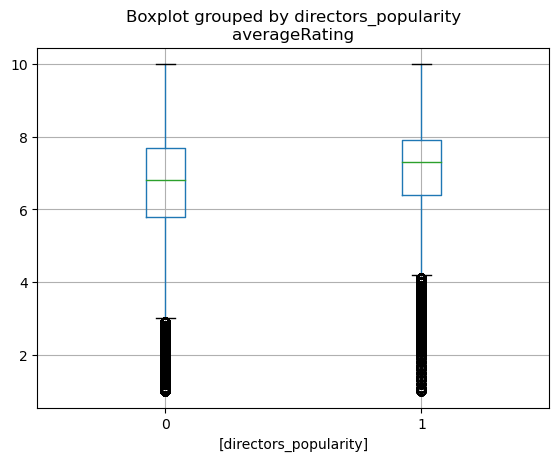

In [227]:
plot = df2.boxplot( column=[ 'averageRating' ], by =[ 'directors_popularity' ] )

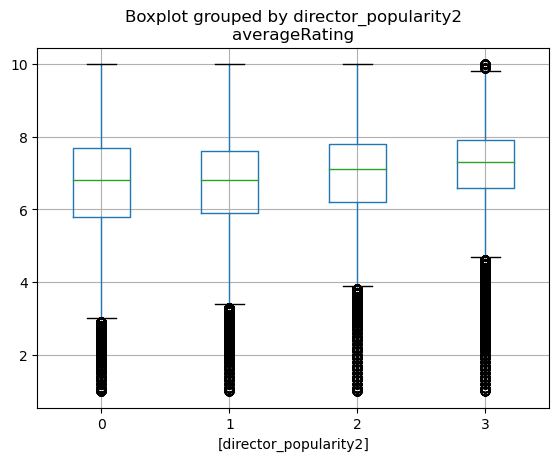

In [229]:
plot = df2.boxplot( column=[ 'averageRating' ], by =[ 'director_popularity2' ] )

### New Preprocessor and Train/Test

In [244]:
import numpy
rng = numpy.random.RandomState( 28 )

from sklearn.model_selection import train_test_split
X2 = df2
y2 = df2['averageRating']
X_train2, X_test2, y_train2, y_test2 = train_test_split( X2, y2, random_state=rng, test_size=0.5 )


df2_reduced = df2.sample(n = 40000, random_state = rng).query( "titleType != 'videoGame' ")
X2_r = df2_reduced
y2_r = df2_reduced['averageRating']
X_train2_r, X_test2_r, y_train2_r, y_test2_r = train_test_split( X2_r, y2_r, random_state=rng, test_size=0.5 )


lstNum2 = list(df.columns[~df.columns.isin(['tconst', 'titleType', 'titleType2', 'primaryTitle', 'originalTitle', 'genres', 'averageRating', 'count_x', 'count_y', 'directors', 'directorList', 'isAdult', 'directors_popularity'])].values)      
lstCat2 = ['titleType2']        

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
pipeNum2 = Pipeline( [
    ('selector', ColumnTransformer([ ('selector' , 'passthrough', lstNum2) ]) ),
    ('scaler', StandardScaler())
])

from sklearn.preprocessing import OneHotEncoder
pipeCat2 = Pipeline([
    ('selector', ColumnTransformer([('selector' , 'passthrough', lstCat2 )]) ),
    ('encoder', OneHotEncoder(dtype = int, drop = 'first', handle_unknown='ignore'))
])

from sklearn.pipeline import FeatureUnion
preprocessor2 = FeatureUnion([
    ('cat', pipeCat2),
    ('num', pipeNum2)
])

### Retrying with GB Tuned Model

In [245]:
pipeGb3 = Pipeline([
    ('preprocessor', preprocessor2 ),
    ('model', GradientBoostingRegressor(learning_rate= 0.15, max_leaf_nodes=50, n_estimators=500) )
    ], verbose=True )

pipeGb3.fit( X_train2_r, y_train2_r )

predTrainGb3_r = pipeGb3.predict(X_train2_r)
predTestGb3_r = pipeGb3.predict(X_test2_r)

print("Gradient Boosted Train Data R^2 Score: ", model.r2_score( y_train2_r, predTrainGb3_r ))
print("Gradient Boosted Test Data R^2 Score: ", model.r2_score( y_test2_r, predTestGb3_r ))

model_test_scores['FE Gb Tuned Reduced Data'] = model.r2_score( y_test2_r, predTestGb3_r )
#score actually lower than original - perhaps simplifying titleType made the model worse

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=  14.4s
Gradient Boosted Train Data R^2 Score:  0.4166657952981918
Gradient Boosted Test Data R^2 Score:  0.308252322547936


In [250]:
#trying again with other FE columns, but keeping original titleType column

lstCat3 = ['titleType']        

pipeCat2 = Pipeline([
    ('selector', ColumnTransformer([('selector' , 'passthrough', lstCat3 )]) ),
    ('encoder', OneHotEncoder(dtype = int, drop = 'first', handle_unknown='ignore'))
])

from sklearn.pipeline import FeatureUnion
preprocessor3 = FeatureUnion([
    ('cat', pipeCat2),
    ('num', pipeNum2)
])

In [251]:
#Retrying with Gb tuned model with original titleType column

pipeGb3 = Pipeline([
    ('preprocessor', preprocessor3 ),
    ('model', GradientBoostingRegressor(learning_rate= 0.15, max_leaf_nodes=50, n_estimators=500) )
    ], verbose=True )

pipeGb3.fit( X_train2_r, y_train2_r )

predTrainGb3_r = pipeGb3.predict(X_train2_r)
predTestGb3_r = pipeGb3.predict(X_test2_r)

print("Gradient Boosted Train Data R^2 Score: ", model.r2_score( y_train2_r, predTrainGb3_r ))
print("Gradient Boosted Test Data R^2 Score: ", model.r2_score( y_test2_r, predTestGb3_r ))

model_test_scores['FE Gb Tuned Reduced Data'] = model.r2_score( y_test2_r, predTestGb3_r )
#score improved

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=  15.9s
Gradient Boosted Train Data R^2 Score:  0.43099120368956123
Gradient Boosted Test Data R^2 Score:  0.32666171094912544


In [252]:
#Retrying with full data

pipeGb3.fit( X_train2, y_train2 )

predTrainGb3 = pipeGb3.predict(X_train2)
predTestGb3 = pipeGb3.predict(X_test2)

print("Gradient Boosted Train Data R^2 Score: ", model.r2_score( y_train2, predTrainGb3 ))
print("Gradient Boosted Test Data R^2 Score: ", model.r2_score( y_test2, predTestGb3 ))

model_test_scores['FE Gb Tuned Full Data'] = model.r2_score( y_test2, predTestGb3 )

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   1.4s
[Pipeline] ............. (step 2 of 2) Processing model, total= 7.8min
Gradient Boosted Train Data R^2 Score:  0.3608749542203733
Gradient Boosted Test Data R^2 Score:  0.3546801666997197


## Results of all models thus far:
- found that the Gradient Boosted Hypertuned model using the full data set has best R^2 score of around 0.355

In [253]:
sorted(model_test_scores.items(), key=lambda x:x[1], reverse = True)

[('Gb Tuned Full Data', 0.35491562014832334),
 ('FE Gb Tuned Full Data', 0.3546801666997197),
 ('Gb Tuned Reduced Data', 0.3273493805212314),
 ('FE Gb Tuned Reduced Data', 0.32666171094912544),
 ('Gb Full Data', 0.31359288607235913),
 ('Rf Reduced Data', 0.3080944518777661),
 ('Gb Reduced Data', 0.3052945825808788),
 ('Nn2 Reduced Data', 0.2886331996398711),
 ('Nn1 Reduced Data', 0.27225844210369265),
 ('LnRg Full Data', 0.23323674956739027)]

# Clustering/Unstructured Modelings

### Kmeans Clustering

In [254]:
from sklearn.cluster import KMeans
pipeKmeans5 = Pipeline([
    ('preprocessor', preprocessor3),
    ('model', KMeans( n_clusters = 5 ))
])

In [256]:
pipeKmeans5.fit(df2)
df2[ 'clusterKmeans5' ] = pipeKmeans5[ 'model' ].labels_

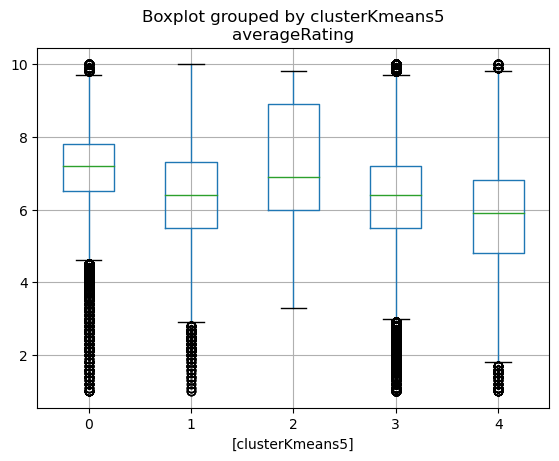

In [108]:
plot = df2.boxplot( column=[ 'averageRating' ], by =[ 'clusterKmeans5' ] )

In [268]:
df2.groupby('clusterKmeans5').averageRating.describe()

,count,mean,std,min,25%,50%,75%,max
clusterKmeans5,,,,,,,,
0,101601.0,7.236438,1.101134,1.0,6.7,7.3,8.0,10.0
1,117735.0,6.870725,1.394304,1.0,6.0,6.9,7.8,10.0
2,87942.0,7.004830,1.273326,1.0,6.4,7.2,7.8,10.0
3,485454.0,6.750615,1.363511,1.0,6.0,7.0,7.7,10.0
4,4747.0,6.867390,1.222514,1.0,6.2,7.0,7.7,10.0


In [269]:
df2.groupby('clusterKmeans5').titleType.value_counts()
#seems to have clustered by title type:
#group 0 having the most movies, 
#group 1 with shorts
#groups 2-4 with tv information

clusterKmeans5  titleType   
0               movie            42900
                tvEpisode        21812
                tvMovie          11175
                short            11140
                video             6763
                tvSeries          4333
                tvMiniSeries      2070
                tvSpecial         1137
                tvShort            271
1               short           109478
                video             5064
                tvEpisode         1304
                tvShort           1258
                tvSeries           390
                tvMiniSeries       117
                tvSpecial          105
                movie               14
                tvMovie              3
                videoGame            2
2               tvEpisode        62532
                movie            16025
                tvSeries          4111
                video             1532
                short             1446
                tvMovie           1

### Reducing Dimensionality
- model has a lot of features (partly due to all the different genres)
- seeking to reduce these features using PCA so that we can have faster processing

In [270]:
from sklearn.decomposition import PCA
from mlxtend.preprocessing import DenseTransformer
pipePcaN = Pipeline([
    ('preprocessor', preprocessor2 ),
    ('todense', DenseTransformer() ),
    ('model', PCA( n_components=0.9 ) )
    ])

pipePcaN.fit( df2 )

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('cat',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnTransformer(transformers=[('selector',
                                                                                                   'passthrough',
                                                                                                   ['titleType2'])])),
                                                                 ('encoder',
                                                                  OneHotEncoder(drop='first',
                                                                                dtype=<class 'int'>,
                                                                                handle_unknown='ignore'))])),
                                                ('num',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnTransformer(transformers=[('selector',
                                                                                                   'passthrou...
                                                                                                    'Adventure',
                                                                                                    'Animation',
                                                                                                    'Biography',
                                                                                                    'Comedy',
                                                                                                    'Crime',
                                                                                                    'Documentary',
                                                                                                    'Drama',
                                                                                                    'Family',
                                                                                                    'Fantasy',
                                                                                                    'Film-Noir',
                                                                                                    'Game-Show',
                                                                                                    'History',
                                                                                                    'Horror',
                                                                                                    'Music',
                                                                                                    'Musical',
                                                                                                    'Mystery',
                                                                                                    'News',
                                                                                                    'Reality-TV',
                                                                                                    'Romance',
                                                                                                    'Sci-Fi',
                                                                                                    'Short',
                                                                                                    'Sport',
                                                                                                    'Talk-Show',
                                                                                                    'Thriller',
                                                                                  

In [271]:
prepDf = pandas.DataFrame( pipePcaN[ :-1 ].fit_transform( df2 ) )
prepDf

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.0,0.0,-4.748806,-0.613314,0.016677,-0.368966,-0.129283,-0.344991,-0.348558,-0.149609,...,-0.077383,-0.150046,-0.301148,-0.176342,2.226158,-0.104894,-0.097973,-0.23291,-0.115201,-0.135774
1,0.0,0.0,-4.838894,-0.569766,-0.061053,-0.368966,-0.129283,-0.344991,2.868961,-0.149609,...,-0.077383,-0.150046,-0.301148,-0.176342,2.226158,-0.104894,-0.097973,-0.23291,-0.115201,-0.135774
2,0.0,0.0,-4.838894,-0.580653,0.007988,-0.368966,-0.129283,-0.344991,2.868961,-0.149609,...,-0.077383,-0.150046,3.320621,-0.176342,2.226158,-0.104894,-0.097973,-0.23291,-0.115201,-0.135774
3,0.0,0.0,-4.838894,-0.493557,-0.065023,-0.368966,-0.129283,-0.344991,2.868961,-0.149609,...,-0.077383,-0.150046,-0.301148,-0.176342,2.226158,-0.104894,-0.097973,-0.23291,-0.115201,-0.135774
4,0.0,0.0,-4.793850,-0.613314,0.045966,-0.368966,-0.129283,-0.344991,-0.348558,-0.149609,...,-0.077383,-0.150046,-0.301148,-0.176342,2.226158,-0.104894,-0.097973,-0.23291,-0.115201,-0.135774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797474,0.0,1.0,0.881690,-0.145172,-0.071143,-0.368966,-0.129283,2.898623,-0.348558,6.684104,...,-0.077383,-0.150046,-0.301148,-0.176342,-0.449204,-0.104894,-0.097973,-0.23291,-0.115201,-0.135774
797475,0.0,1.0,0.566382,-0.515331,-0.072824,-0.368966,-0.129283,2.898623,2.868961,-0.149609,...,-0.077383,-0.150046,-0.301148,-0.176342,-0.449204,-0.104894,-0.097973,-0.23291,-0.115201,-0.135774
797476,0.0,1.0,0.566382,-0.515331,-0.072871,-0.368966,-0.129283,2.898623,2.868961,-0.149609,...,-0.077383,-0.150046,-0.301148,-0.176342,-0.449204,-0.104894,-0.097973,-0.23291,-0.115201,-0.135774
797477,0.0,1.0,0.566382,-0.515331,-0.072871,-0.368966,-0.129283,2.898623,2.868961,-0.149609,...,-0.077383,-0.150046,-0.301148,-0.176342,-0.449204,-0.104894,-0.097973,-0.23291,-0.115201,-0.135774


In [272]:
#reduced from 33 to 26
tempPCA = pipePcaN.transform( df2 )
dfPca = pandas.DataFrame( tempPCA )
dfPca = dfPca.add_prefix('pca_')
dfPca

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25
0,-0.018312,-1.564656,-0.793180,2.242059,-0.506636,1.313191,2.577229,-1.383834,-0.458719,0.247050,...,0.368808,0.703011,-0.092445,1.139287,0.186178,0.773667,-0.756189,-0.124475,-3.089966,-0.699954
1,-1.906475,-0.098994,-1.736051,1.596857,-0.584200,1.219389,2.221391,-1.465018,-1.080084,0.067007,...,0.208250,0.812614,0.905801,-0.483374,0.217150,1.788867,-0.117357,1.114473,-2.463649,-0.651504
2,-2.090510,-0.585722,-3.454603,1.013846,0.395370,1.096848,0.431758,-0.946646,-1.674879,0.808538,...,-0.874893,0.277489,-0.201288,-0.840200,-0.872646,2.016742,-0.797683,1.365887,-3.567004,0.145403
3,-1.891853,-0.095620,-1.732300,1.598873,-0.562342,1.222282,2.223688,-1.429926,-1.066934,0.072278,...,0.210500,0.804680,0.909492,-0.463067,0.243876,1.823011,-0.101511,1.136250,-2.463687,-0.637078
4,-0.877034,-0.963013,-2.723087,0.917816,-0.164518,0.941196,1.976445,-1.174749,-0.710852,-0.007373,...,0.181564,0.670127,0.021059,-0.666260,1.258920,0.645979,-0.122391,0.313022,-3.095962,-0.576441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797474,-1.142863,-0.752074,2.057817,1.522619,1.252781,-0.307877,-1.498708,0.018878,1.261036,-0.965681,...,-1.970470,-1.039422,0.914926,-3.156403,2.001591,0.167144,-3.450365,1.309641,0.584575,-0.255517
797475,-3.519771,0.669599,0.425390,0.048547,0.218636,-0.444815,-0.696617,-0.225043,0.262811,0.261758,...,-0.542187,-0.120544,-0.631080,-0.722430,-0.422531,0.584713,0.095298,0.992071,0.715148,-1.020790
797476,-3.519771,0.669595,0.425389,0.048546,0.218635,-0.444814,-0.696615,-0.225054,0.262809,0.261763,...,-0.542184,-0.120573,-0.631076,-0.722433,-0.422528,0.584713,0.095297,0.992073,0.715147,-1.020789
797477,-3.519771,0.669595,0.425389,0.048546,0.218635,-0.444814,-0.696615,-0.225054,0.262809,0.261763,...,-0.542184,-0.120573,-0.631076,-0.722433,-0.422528,0.584713,0.095297,0.992073,0.715147,-1.020789


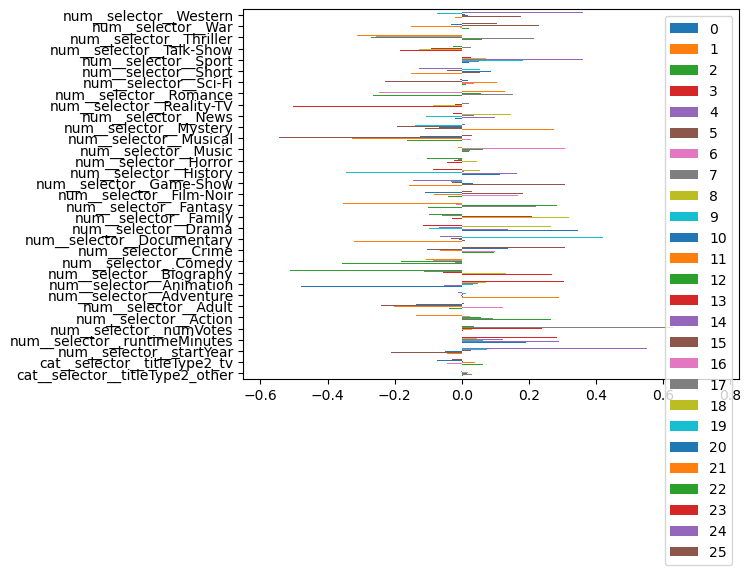

In [273]:
import numpy
dfComponents = pandas.DataFrame( numpy.transpose( pipePcaN[ 'model' ].components_ ) )
dfComponents.index = pipePcaN['preprocessor'].get_feature_names_out()
plot = dfComponents.plot.barh()

In [274]:
pipeGbPca = Pipeline([
    ('pca', pipePcaN),
    ('model', GradientBoostingRegressor(learning_rate= 0.15, max_leaf_nodes=5, n_estimators=500) )
    ], verbose=True )

pipeGbPca.fit( X_train2_r, y_train2_r )

predTrainGbPca_r = pipeGbPca.predict(X_train2_r)
predTestGbPca_r = pipeGbPca.predict(X_test2_r)

print("Gradient Boosted Train Data R^2 Score: ", model.r2_score( y_train2_r, predTrainGbPca_r ))
print("Gradient Boosted Test Data R^2 Score: ", model.r2_score( y_test2_r, predTestGbPca_r ))

model_test_scores['PCA FE Gb Tuned Reduced Data'] = model.r2_score( y_test2_r, predTestGbPca_r )

[Pipeline] ............... (step 1 of 2) Processing pca, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total= 1.2min
Gradient Boosted Train Data R^2 Score:  0.3768869307605912
Gradient Boosted Test Data R^2 Score:  0.2383889357309673
